# Developing an AI application

## **NOTE:** 


Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

# Tips, Model Performance, Submission Troubleshooting, etc 


In [0]:
# google colab does not come with torch installed. And also, in course we are using torch 0.4. 
# so following snippet of code installs the relevant version

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [4]:
!pip install numpy

In [0]:

# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
from torchvision.transforms import ToTensor
from collections import OrderedDict
import json

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# TODO: Define your transforms for the training and validation sets
#data_transforms = 
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder
#image_datasets = 
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
#dataloaders = 
train_dataloaders = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_dataloaders = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# TODO: Build and train your network
# TODO: Build and train your network


def set_model(hidden_layers,architecture):
    
    if architecture == 'resnet18':
        model = models.resnet18(pretrained=True)
        input_size = model.fc.in_features
    elif architecture == 'alexnet':
        model = models.alexnet(pretrained=True)
        input_size = model.classifier[1].in_features
    elif architecture == 'densenet161':
        model = models.densenet161(pretrained=True)
        input_size = model.classifier.in_features
    elif architecture == 'inception_v3':
        model = models.inception_v3(pretrained=True)
        input_size = model.fc.in_features
    else:
        model = models.vgg16(pretrained=True)
        input_size = model.classifier[0].in_features

    #model = models.vgg16(pretrained=True)
    #print(model)

    for param in model.parameters():
        param.requires_grad = False



    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, 4096)),
                          ('relu1', nn.ReLU()),
                          ('dropout1',nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(4096, hidden_layers)),
                          ('relu2', nn.ReLU()),
                          ('dropout2',nn.Dropout(p=0.2)),
                          ('fc3', nn.Linear(hidden_layers, 392)),
                          ('relu3', nn.ReLU()),
                          ('dropout3',nn.Dropout(p=0.2)),
                          ('fc4', nn.Linear(392, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    if architecture == 'resnet18' or architecture == 'inception_v3':
        model.fc = classifier
    else:
        model.classifier = classifier
    
    return model

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
architecture = 'densenet161'
hidden_units = 1024
model = set_model(hidden_units,architecture)
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

model.to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in valid_dataloaders:
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        if torch.cuda.is_available():
            equality = equality.type(torch.cuda.FloatTensor)
        accuracy += equality.mean()
    
    return test_loss, accuracy

In [0]:
def train_model(model,train_dataloaders,valid_dataloaders,optimizer,criterion,device,epochs):

#epochs = 5
    print_every = 100
    steps = 0

    for e in range(epochs):
        model.train()
        running_loss = 0
        for (inputs, labels) in train_dataloaders:
            steps += 1
            # Move input and label tensors to the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            #print(type(inputs))
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()
                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    test_loss, accuracy = validation(model, valid_dataloaders, criterion)
                print("Epoch: {}/{}... ".format(e+1, epochs),"Loss: {:.4f}".format(running_loss/print_every))
                print("Validation Loss: {:.4f}".format(test_loss/len(valid_dataloaders)))
                print("Validation Accuracy: {:.4f}".format(accuracy/len(valid_dataloaders)))
            
                running_loss = 0
                # Make sure training is back on
                model.train()

In [14]:
train_model(model,train_dataloaders,valid_dataloaders,optimizer,criterion,device,10)

Epoch: 1/10...  Loss: 4.3485
Validation Loss: 3.6982
Validation Accuracy: 0.2713
Epoch: 2/10...  Loss: 3.0483
Validation Loss: 2.1419
Validation Accuracy: 0.4786
Epoch: 3/10...  Loss: 1.9237
Validation Loss: 1.3754
Validation Accuracy: 0.6588
Epoch: 4/10...  Loss: 1.3803
Validation Loss: 0.9418
Validation Accuracy: 0.7719
Epoch: 5/10...  Loss: 1.0774
Validation Loss: 0.7505
Validation Accuracy: 0.8299
Epoch: 6/10...  Loss: 0.8678
Validation Loss: 0.5779
Validation Accuracy: 0.8644
Epoch: 7/10...  Loss: 0.7518
Validation Loss: 0.5022
Validation Accuracy: 0.8865
Epoch: 8/10...  Loss: 0.6544
Validation Loss: 0.4322
Validation Accuracy: 0.8934
Epoch: 9/10...  Loss: 0.5710
Validation Loss: 0.4006
Validation Accuracy: 0.9126
Epoch: 10/10...  Loss: 0.5053
Validation Loss: 0.3750
Validation Accuracy: 0.9143


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [66]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# TODO: Save the checkpoint 
def save_model():
    checkpoint = {'architecture':architecture,
                  'hidden units':hidden_units,
                  'state_dict': model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'mapping':train_data.class_to_idx,
                  'num_epoch':10
                 }
    path = "/content/gdrive/My Drive/checkpoint.pth" 
    torch.save(checkpoint, path)
    
    
save_model()

In [69]:
!ls "/content/gdrive/My Drive"


 20151227_185339.jpg
 20151227_190533.jpg
 2016-05-04-10-16-24--122768225.gdoc
 3dsearching.pptx
'5 DIEBOLD NIXDORF Sree Lakshmi Addepalli '
 AnnexureE.pdf
 Applications
'Asset_List_Gowri lakshmi.xls.xlsx'
'Asset_List_Gowri lakshmi.xls.xlsx.gsheet'
 ASU_Resume_SreeLakshmiAddepalli.gdoc
 BCEfinal.pptx
 BCEPresentationfinal.pptx
 BigOAnalysis.gsheet
 CEACAA007XD97O.PDF
 checkpoint.pth
'Complete Blood Count(CBC).pdf'
'Copy of Immovable Property.xls'
 Cybercrimeawareness.pptx
'Diebold nixdorf annual day pics'
 dvhacks
'FINAL CSI.doc'
'FINAL CSI.doc.gdoc'
'Google Buzz'
'GOWRI SOP FINAL.docx'
'GOWRI SOP FINAL.docx.gdoc'
 GRE
'HAPPY BIRTHDAY.pptx'
'Hemant _Lor_Lakshmi (1).docx.gdoc'
'Hemant _Lor_Lakshmi.docx'
'Hemant _Lor_Lakshmi.docx.gdoc'
'Lakshmi_Hemantsir Lor.gdoc'
 Lakshmi_Resume.docx
 Lakshmi_Resume.docx.gdoc
 Lakshmi_Resume_Final.docx
'Lakshmi_V.2 final.docx'
'Lakshmi_V.2 final.docx.gdoc'
 Lor-manisha.docx
 Lor-manisha.docx.gdoc
 ml
 {model_save_name}
 MyMS
 Nyu
'NYU Tandon - Housing, 

In [0]:
idx_to_class = dict()
for key,value in train_data.class_to_idx.items():
    idx_to_class[value] = key

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    #model = fc_model.Network(checkpoint['input_size'],checkpoint['output_size'],checkpoint['hidden_layers'])
    model = set_model(hidden_units,architecture)
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['mapping']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    im = Image.open(image)
    width, height = im.size
    #print(width,height)
    size = 256,(height*256)/width
    if(width > height):
        size = (width*256)/height,256
    im.thumbnail(size)
    width, height = im.size
    #print(width,height)
    new_width = 224;
    new_height=224;
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    im = im.crop((left, top, right, bottom))
    width, height = im.size
    #print(width,height)

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]

    # TODO: Process a PIL image for use in a PyTorch model
    np_image = np.array(im)
    np_image_min = np_image.min(axis=(0, 1), keepdims=True)
    np_image_max = np_image.max(axis=(0, 1), keepdims=True)
    np_image = (np_image - np_image_min)/(np_image_max-np_image_min)
    #np_image = np_image/255
    normalised_image=(np_image-mean)/std
    normalised_image.transpose(2,0,1)
    return normalised_image.transpose(2,0,1)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    outputs = model(image_path)
    ps = torch.exp(outputs).data
    return torch.topk(input=ps, k=topk)

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes
def sanity_check(image_path):
    preprocess = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    img_path=image_path
    image = Image.open(img_path)
    nmp_tensor = process_image(img_path)
    img_tensor = torch.from_numpy(nmp_tensor)
    if torch.cuda.is_available():
        img_tensor = img_tensor.type(torch.cuda.FloatTensor)
    image = img_tensor.unsqueeze(0) 
    image = image.to(device)

    probs, classes = predict(image,model)
    class1 = classes.cpu().numpy()
    prob = probs.cpu().numpy()
    class_names = []
    for x in np.nditer(class1):
        class_value = idx_to_class.get(int(x))
        class_names.append(cat_to_name.get(class_value))
    z = prob[0,:]
    y = np.arange(len(class_names))
    fig=plt.figure(figsize=(5,5))

    imshow(process_image(image_path))


    fig= plt.figure(figsize=(10,10))
    plt.barh( y, z, align='center')
    plt.yticks(y,class_names)
    plt.xlabel('Probability')
    plt.title('Predicted flower')
    plt.show()

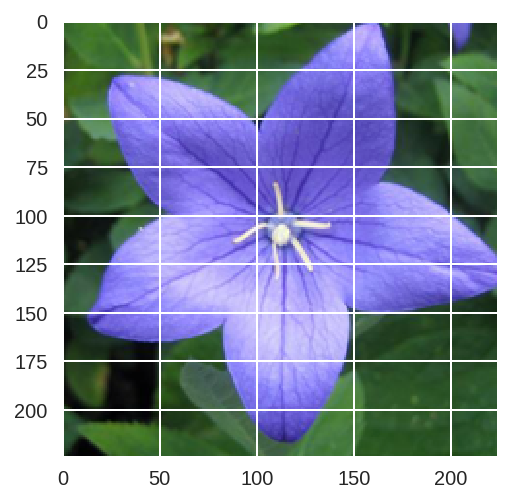

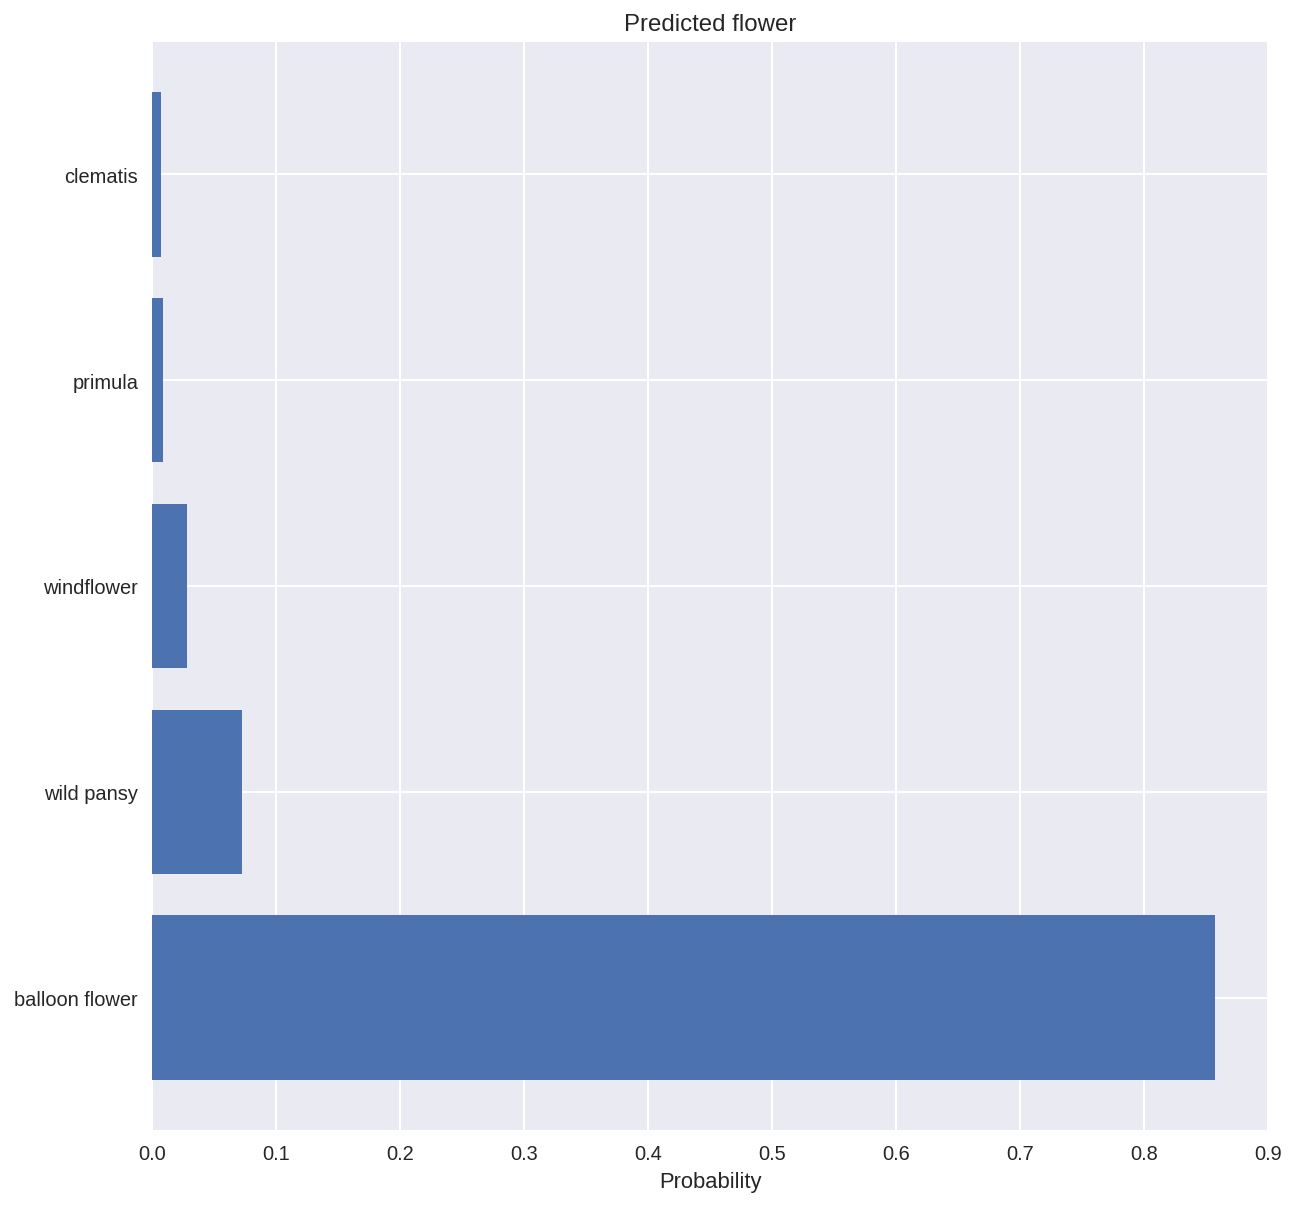

In [22]:
sanity_check('flower_data/train/19/image_06177.jpg')